# **ML-based estimation of battery capacity and RUL prediction**

## Utilized dataset : NASA battery dataset

source: https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

### Steps to follow

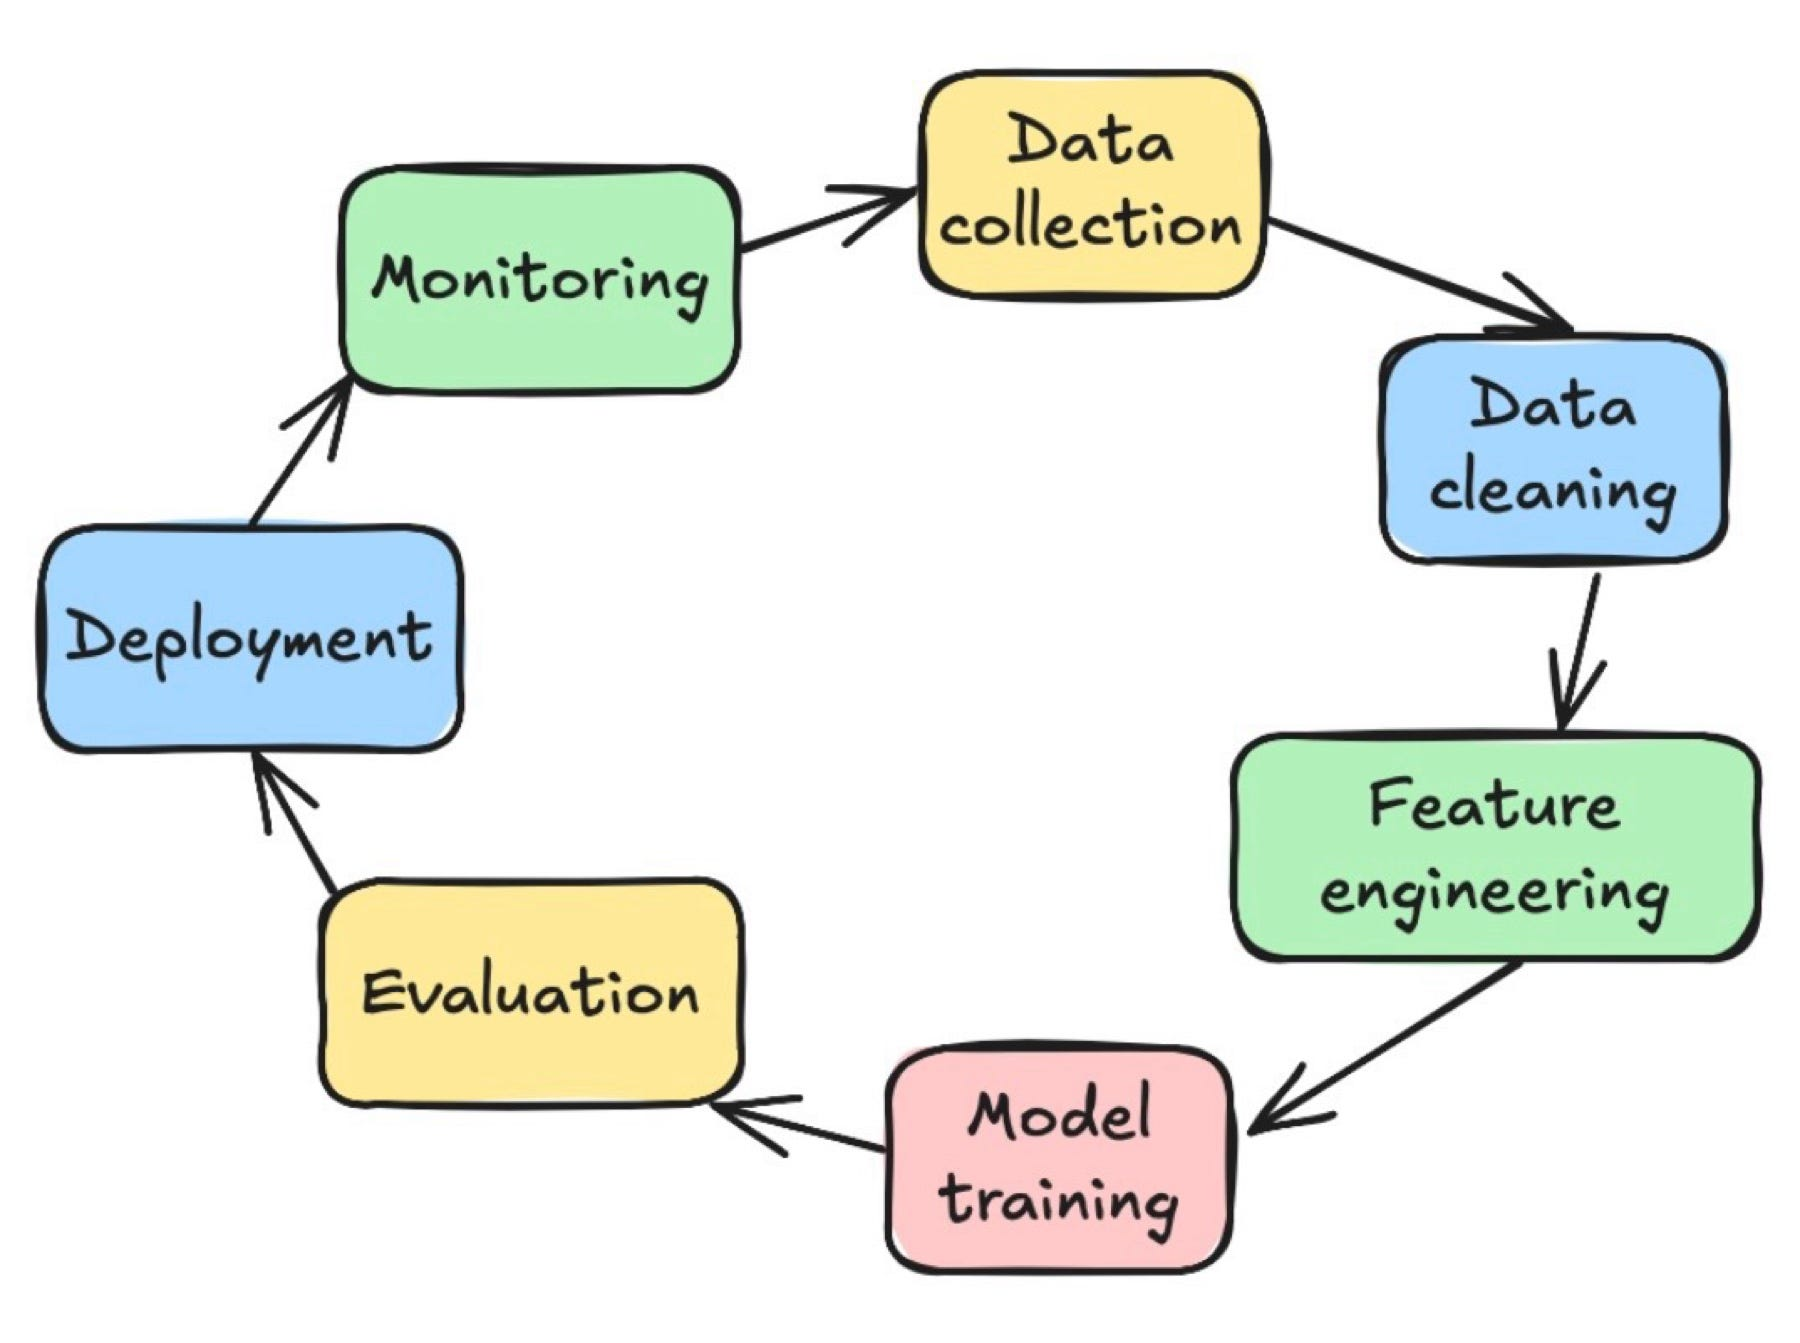

In [ ]:
# Install required packages

# !pip install seaborn
# !pip install matplotlib
# !pip install pandas
# !pip instal scikit-learn
# !pip install numpy
# !pip install xgboost

In [151]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Selected NASA 18,650 Batteries (B0005, B0006, B0007, B0018) for this task.

**Data Description:**
A set of four Li-ion batteries **(#5, #6, #7 and #18)** were run through 3 different operational profiles (charge, discharge and impedance) at room temperature. 

**battery parameters**
Nominal capicity 2Ah

**Charging Process:**
- Constant current (CC) mode at 1.5A until battery voltage reached 4.2V 
- Followed by constant voltage (CV) mode until charge current dropped to 20mA

**Discharge Process:**
- Constant current (CC) level of 2A until battery voltage fell to final discharge voltages:
	- Battery #5: 2.7V
	- Battery #6: 2.5V 
	- Battery #7: 2.2V
	- Battery #18: 2.5V

**End of Life (EOL) Criteria:**
- 30% fade in rated capacity (from 2Ah to 1.4Ah)

**Discharge Fields:**
- Voltage_measured: Battery terminal voltage (Volts)
- Current_measured: Battery output current (Amps)  
- Temperature_measured: Battery temperature (°C)
- Current_charge: Current measured at load (Amps)
- Voltage_charge: Voltage measured at load (Volts)
- Time: Time vector for the cycle (secs)
- Capacity: Battery capacity (Ah) for discharge till final discharge voltage.

## Equivalent circuit for the experiment

In [ ]:
# Load the data
# The data is in .mat format, which is a MATLAB file format.
def load_data(battery):
    mat = loadmat("battery_data/" + battery + ".mat")
    print("Total data in dataset: ", len(mat[battery][0, 0]["cycle"][0]))
    counter = 0
    dataset = []

    for i in range(len(mat[battery][0, 0]["cycle"][0])):
        row = mat[battery][0, 0]["cycle"][0, i]
        if row["type"][0] == "discharge":
            data = row["data"]
            capacity = data[0][0]["Capacity"][0][0]
            for j in range(len(data[0][0]["Voltage_measured"][0])):
                voltage_measured = data[0][0]["Voltage_measured"][0][j]
                current_measured = data[0][0]["Current_measured"][0][j]
                temperature_measured = data[0][0]["Temperature_measured"][0][j]
                current_load = data[0][0]["Current_load"][0][j]
                voltage_load = data[0][0]["Voltage_load"][0][j]
                time = data[0][0]["Time"][0][j]
                dataset.append(
                    [
                        counter + 1,
                        capacity,
                        voltage_measured,
                        current_measured,
                        temperature_measured,
                        current_load,
                        voltage_load,
                        time,
                    ]
                )
            counter = counter + 1

    return [pd.DataFrame(data=dataset,
                        columns=['cycle','capacity','voltage_measured','current_measured','temperature_measured','current_load',      'voltage_load', 'time']
                                )] 
dataset_5 = load_data("B0005") 
dataset_6 = load_data("B0006")
dataset_7 = load_data("B0007")
dataset_18 = load_data("B0018")

Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  319


In [121]:
df_5 = dataset_5[0]
df_6 = dataset_6[0]
df_7 = dataset_7[0]
df_18 = dataset_18[0]

df_5.head()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


In [120]:
df_5.tail()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
50280,168,1.325079,3.579262,-0.001569,34.864823,0.0006,0.0,2781.312
50281,168,1.325079,3.581964,-0.003067,34.814770,0.0006,0.0,2791.062
50282,168,1.325079,3.584484,-0.003079,34.676258,0.0006,0.0,2800.828
50283,168,1.325079,3.587336,0.001219,34.565580,0.0006,0.0,2810.640
50284,168,1.325079,3.589937,-0.000583,34.405920,0.0006,0.0,2820.390


In [122]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cycle                 50285 non-null  int64  
 1   capacity              50285 non-null  float64
 2   voltage_measured      50285 non-null  float64
 3   current_measured      50285 non-null  float64
 4   temperature_measured  50285 non-null  float64
 5   current_load          50285 non-null  float64
 6   voltage_load          50285 non-null  float64
 7   time                  50285 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.1 MB


### There are no NULL values

In [123]:
df_5.describe()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


### Check for outliers

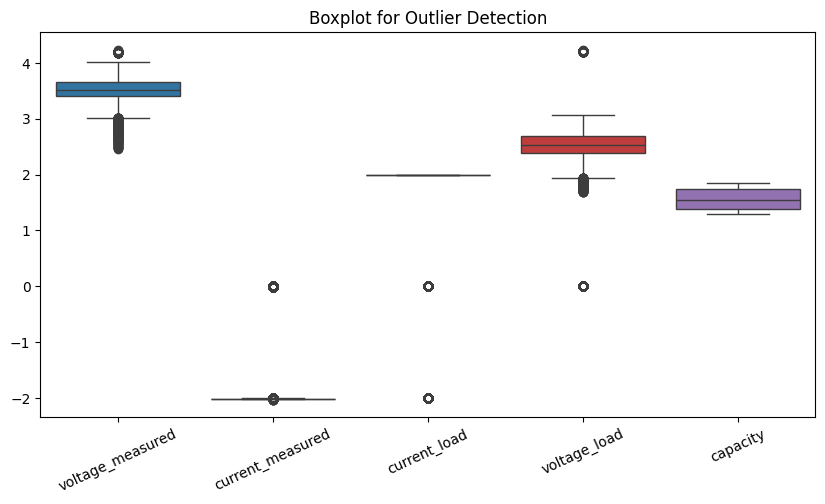

In [126]:
# Plot boxplots for all numerical features
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_5[
        [
            "voltage_measured",
            "current_measured",
            "current_load",
            "voltage_load",
            "capacity",
        ]
    ]
)
plt.xticks(rotation=25)
plt.title("Boxplot for Outlier Detection")
plt.show()

## Clean outliers

In [175]:
df_5_clean = df_5.copy()
# Remove outliers

for col in ["voltage_measured",  "voltage_load"]:
    df_5_clean[col] = df_5_clean[col].clip(
        lower=df_5_clean[col].quantile(0.005), upper=df_5_clean[col].quantile(0.995)
    ) # 3% and 97% quantile replacement


for col in ["current_measured",  "current_load"]:
    df_5_clean[col] = df_5_clean[col].clip(
        lower=df_5_clean[col].quantile(0.01), upper=df_5_clean[col].quantile(0.995)
    )  # 3% and 97% quantile replacement

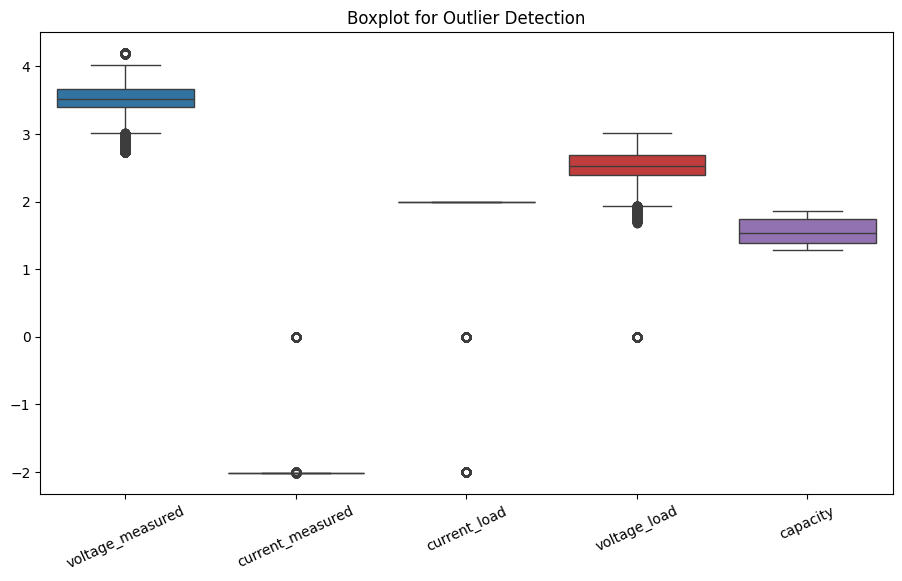

In [176]:
# Plot boxplots for all numerical features
plt.figure(figsize=(11, 6))
sns.boxplot(
    data=df_5_clean[
        [
            "voltage_measured",
            "current_measured",
            "current_load",
            "voltage_load",
            "capacity",
        ]
    ]
)
plt.xticks(rotation=25)
plt.title("Boxplot for Outlier Detection")
plt.show()

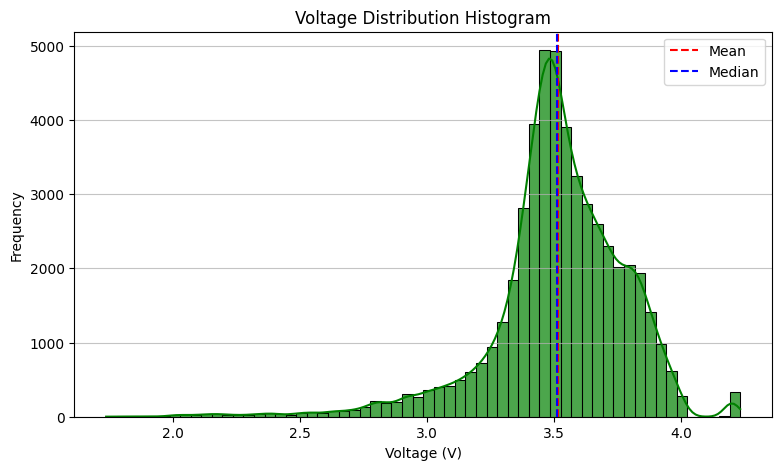

In [177]:
plt.figure(figsize=(9, 5))
sns.histplot(df["voltage_measured"], kde=True, bins=60, color="green", alpha=0.7)
plt.title("Voltage Distribution Histogram")
plt.grid(axis="y", alpha=0.75)
plt.axvline(df_5_clean["voltage_measured"].mean(), color="red", linestyle="--", label="Mean")
plt.axvline(df_5_clean["voltage_measured"].median(), color="blue", linestyle="--", label="Median")
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Frequency")
plt.show()

/tmp/ipykernel_3570102/1515823291.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


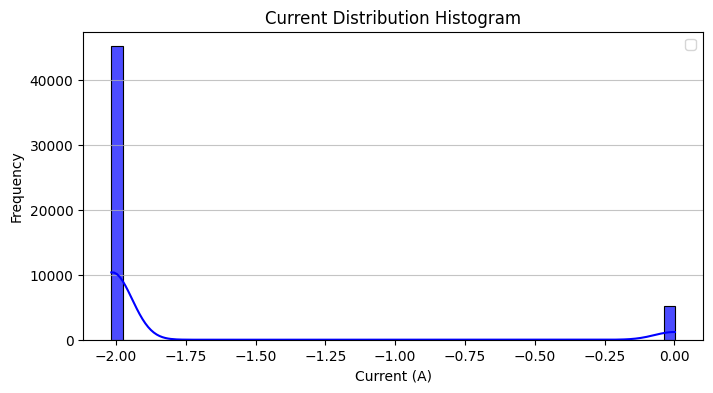

In [178]:
plt.figure(figsize=(8, 4))
sns.histplot(df_5_clean["current_measured"], kde=True, bins=50, color="blue", alpha=0.7)
plt.title("Current Distribution Histogram")
plt.grid(axis="y", alpha=0.75)
plt.legend()
plt.xlabel("Current (A)")
plt.ylabel("Frequency")
plt.show()

In [179]:
df_5_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cycle                 50285 non-null  int64  
 1   capacity              50285 non-null  float64
 2   voltage_measured      50285 non-null  float64
 3   current_measured      50285 non-null  float64
 4   temperature_measured  50285 non-null  float64
 5   current_load          50285 non-null  float64
 6   voltage_load          50285 non-null  float64
 7   time                  50285 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.1 MB


In [180]:
df_5_clean.describe()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,1.560345,3.515575,-1.806020,32.816991,1.362702,2.304401,1546.208924
std,45.699687,0.182380,0.230577,0.610483,3.987515,1.313694,0.793742,906.640295
min,1.000000,1.287453,2.736510,-2.016303,23.214802,-1.998200,0.000000,0.000000
25%,50.000000,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,1.856487,4.194981,0.001701,41.450232,1.998400,3.021000,3690.234000


### **Eploratory Data analysis (EDA)**

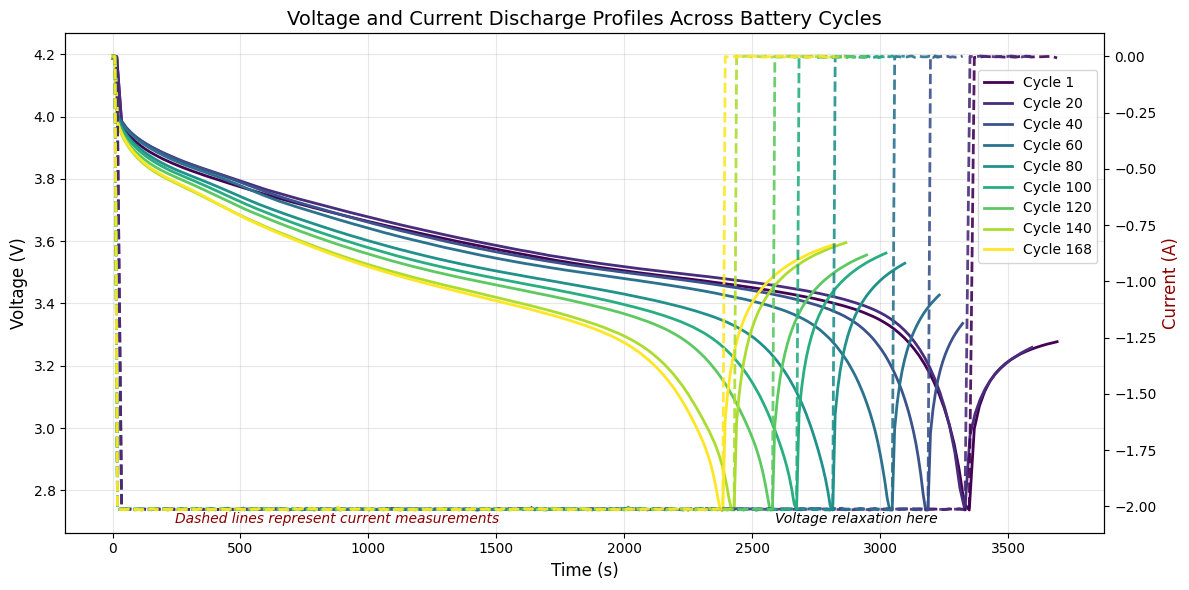

In [261]:
# relationship between voltage and time - colored by cycle, with current on secondary axis
plt.figure(figsize=(12, 6))

# Create two axes sharing the same x-axis
ax1 = plt.gca()
ax2 = ax1.twinx()

# Sample a subset of cycles to avoid overcrowding the plot
sample_cycles = [1, 20, 40, 60, 80, 100, 120, 140, 168]  # Including first and last cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_cycles)))

for i, cycle_num in enumerate(sample_cycles):
    cycle_data = df_5_clean[df_5_clean['cycle'] == cycle_num]
    
    # Plot voltage on the primary y-axis
    ax1.plot(cycle_data['time'], cycle_data['voltage_measured'], 
             color=colors[i], label=f'Cycle {cycle_num}', linewidth=2)
    
    # Plot current on the secondary y-axis with dashed lines
    ax2.plot(cycle_data['time'], cycle_data['current_measured'], 
             color=colors[i], linestyle='--', alpha=0.9, linewidth=2)

# Set labels and title
ax1.set_title("Voltage and Current Discharge Profiles Across Battery Cycles", fontsize=14)
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Voltage (V)", fontsize=12, color='black')
ax2.set_ylabel("Current (A)", fontsize=12, color='darkred')

# Add grid lines for clarity
ax1.grid(True, alpha=0.3)

# Add a single legend for voltage curves
ax1.legend(loc="upper right", bbox_to_anchor=(1, 0.94))  #

# Annotate the current curves
plt.figtext(0.15, 0.12, "Dashed lines represent current measurements", 
            fontsize=10, style='italic', color='darkred')

plt.figtext(
    0.65,
    0.12,
    "Voltage relaxation here",
    fontsize=10,
    style="italic",
    color="black",
)

plt.tight_layout()
plt.show()

### More research is needed to understand the effect of voltage relaxation to the RUL prediction

### End of Discharge voltage was 2.7 V

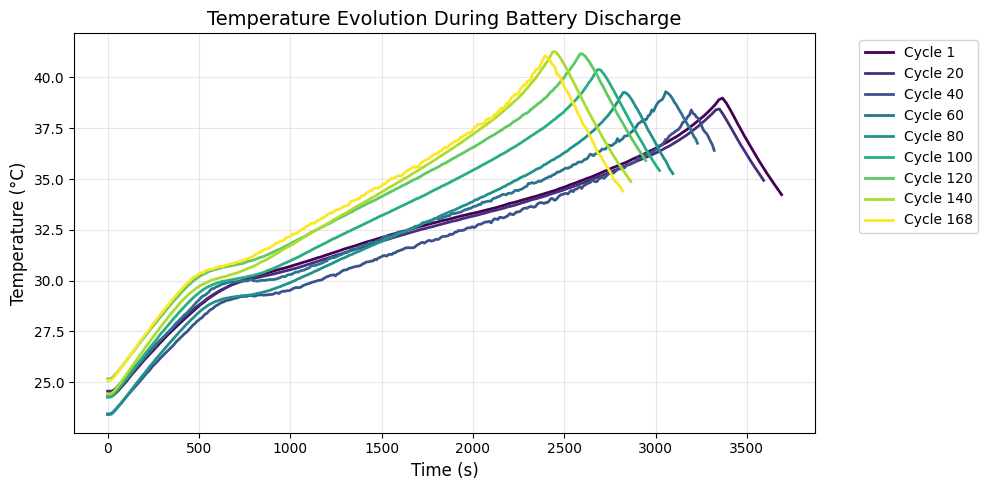

In [244]:
# relationship between temperature and time - colored by cycle
plt.figure(figsize=(10, 5))

# Sample a subset of cycles to avoid overcrowding the plot
sample_cycles = [1, 20, 40, 60, 80, 100, 120, 140, 168]  # Including first and last cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_cycles)))

for i, cycle_num in enumerate(sample_cycles):
    cycle_data = df_5_clean[df_5_clean['cycle'] == cycle_num]
    plt.plot(cycle_data['time'], cycle_data['temperature_measured'], 
             color=colors[i], label=f'Cycle {cycle_num}', linewidth=2)

plt.title("Temperature Evolution During Battery Discharge", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Battery temperature increases with discharge time 

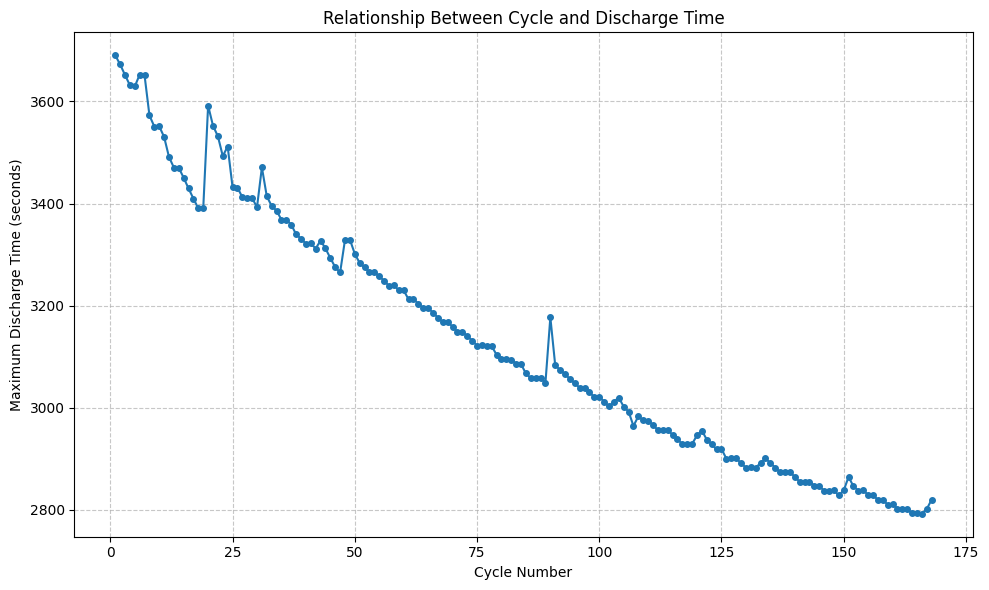

In [ ]:
# Group by cycle and calculate the discharge time for each cycle
discharge_time = df_5_clean.groupby('cycle')['time'].max()
cycles = discharge_time.index

# Plot the relationship between cycle and discharge time
plt.figure(figsize=(10, 6))
plt.plot(cycles, discharge_time.values, marker='o', linestyle='-', markersize=4)
plt.title('Relationship Between Cycle and Discharge Time')
# plt.legend(['Discharge Time', 'Battery Capacity'])
plt.xlabel('Cycle Number')
plt.ylabel('Maximum Discharge Time (s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### Discharge time decreases with number of discharge cycles. Similar to battery capacity.

## Feature Engineering.

List of features to engineer

Feature Engineering (temperature fluctuations, internal resistance, cycle count, depth of discharge (DoD), and charge/discharge rates) Methods to extract detailed information, such as voltage relaxation characteristics and charge capacity fading patterns

In [190]:
df_5_clean.head()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,1.856487,4.190749,-0.001478,24.325993,-0.0006,3.021,16.781
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.021,35.703
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.021,53.781
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


### Add SoC to the dataset:  **Coulomb Counting method**

### Formula: SoC(t) = SoC(t-1) + (I(t) * dt) / Capacity

### SoC relationship per cycle. Not time. Add 

In [285]:
initial_soc = 1.0  # start each cycle at 100% SoC

# compute Δt per cycle in hours
df_5_clean["dt_seconds"] = df_5_clean.groupby("cycle")["time"].diff().fillna(0)
df_5_clean["dt_hours"] = df_5_clean["dt_seconds"] / 3600.0

# compute charge removed dQ in Ah
df_5_clean["dQ_Ah"] = df_5_clean["current_measured"] * df_5_clean["dt_hours"]

# compute cumulative relative change within each cycle
cumulative_relative_charge_change = (
    df_5_clean.groupby("cycle")
    .apply(lambda g: (g["dQ_Ah"] / g["capacity"]).cumsum())  # g["capacity"]
    .reset_index(level=0, drop=True)
)

# SoC = initial_soc + cumulative change, clipped to [0,1]
df_5_clean["SoC"] = (initial_soc + cumulative_relative_charge_change).clip(0, 1)

# clean up helper columns
df_5_clean.drop(columns=["dt_seconds", "dt_hours", "dQ_Ah"], inplace=True)

/tmp/ipykernel_3570102/392397687.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["dQ_Ah"] / g["capacity"]).cumsum())  # g["capacity"]


In [286]:
df_5_clean.head()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,SoC,DOD
0,1,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.000000,0.000000
1,1,1.856487,4.190749,-0.001478,24.325993,-0.0006,3.021,16.781,0.999996,0.000004
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.021,35.703,0.994298,0.005702
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.021,53.781,0.988851,0.011149
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,0.983392,0.016608


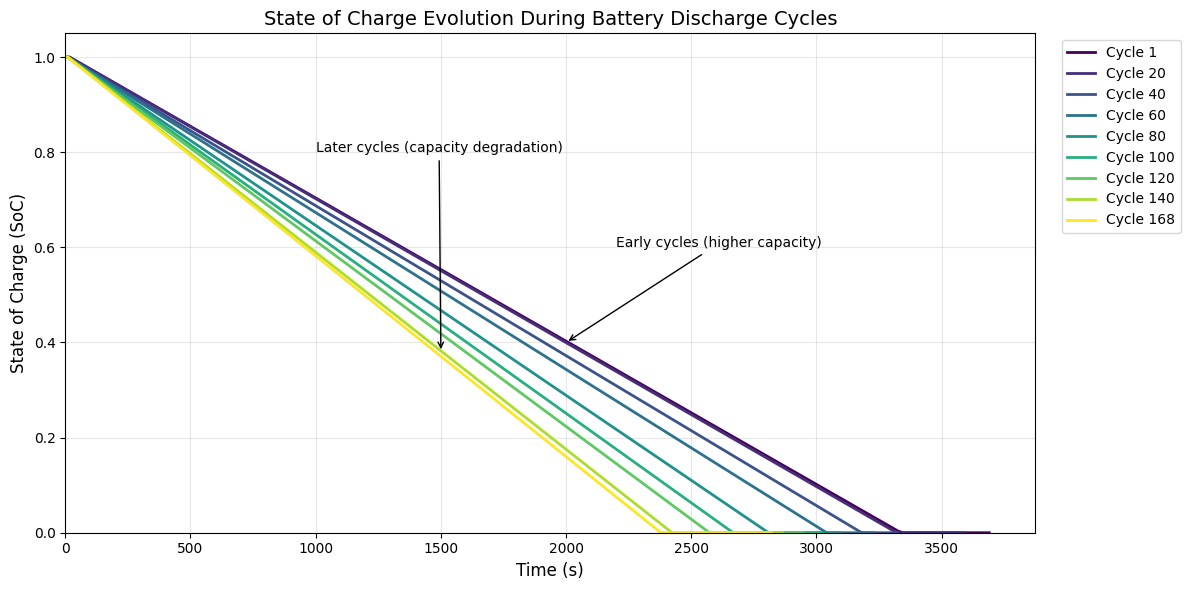

In [287]:
# relationship between SoC and time - colored by cycle
plt.figure(figsize=(12, 6))

# Sample a subset of cycles to avoid overcrowding the plot
sample_cycles = [1, 20, 40, 60, 80, 100, 120, 140, 168]  # Including first and last cycle
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_cycles)))

for i, cycle_num in enumerate(sample_cycles):
    cycle_data = df_5_clean[df_5_clean["cycle"] == cycle_num]
    plt.plot(
        cycle_data["time"], 
        cycle_data["SoC"],
        color=colors[i],
        label=f"Cycle {cycle_num}",
        linewidth=2
    )

plt.title("State of Charge Evolution During Battery Discharge Cycles", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("State of Charge (SoC)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.ylim(0, 1.05)
plt.xlim(0, None)

# Add annotations to highlight battery aging
plt.annotate('Early cycles (higher capacity)',
             xy=(2000, 0.4), xytext=(2200, 0.6),
             arrowprops=dict(arrowstyle="->", color='black'))
             
plt.annotate('Later cycles (capacity degradation)',
             xy=(1500, 0.38), xytext=(1000, 0.8),
             arrowprops=dict(arrowstyle="->", color='black'))

plt.tight_layout()
plt.show()

### Compute delta SOC for each cycle and use it as a feature

### Full discharge cycles which are not realistic in the real world

In [266]:
# DOD (Depth of Discharge)
df_5_clean["DOD"] = 1 - df_5_clean["SoC"]
df_5_clean.head()

,cycle,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,SoC,DOD
0,1,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.000000,0.000000
1,1,1.856487,4.190749,-0.001478,24.325993,-0.0006,3.021,16.781,0.999996,0.000004
2,1,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.021,35.703,0.994298,0.005702
3,1,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.021,53.781,0.988851,0.011149
4,1,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,0.983392,0.016608


### important features

In [360]:
# Create a new DataFrame to store engineered features per cycle
features = pd.DataFrame()

# Group by cycle for feature calculation
cycle_groups = df_5_clean.groupby("cycle")

init_capacity = 2.0 # Nominal capacity in Ah
print("Nominal capacity: ", init_capacity)

eol_capacity = 1.4 # End of life capacity in Ah. 30% fade of nominal capacity
print("End of life capacity: ", eol_capacity)

features["cycle"] = sorted(df_5_clean["cycle"].unique()) # Cycle number

total_cycles = features["cycle"].max() # Total number of cycles
print("Total number of cycles: ", total_cycles)

features["capacity"] = (cycle_groups["capacity"].first().values)  # Capacity at the beginning of each cycle

eol_cycle = features[features["capacity"] <= eol_capacity].cycle.min()  # Cycle number at end of life
print("End of life cycle: ", eol_cycle)

# SOH (State of Health)
features["SOH"] = features["capacity"] / init_capacity

# rate of change of SoC (State of Charge) per hour
features["delta_SOC"] = -(cycle_groups["SoC"].first().values - cycle_groups["SoC"].last()).values / ((cycle_groups["time"].max().values - cycle_groups["time"].min()).values / 3600)  # dSOC/dt (1/hour)

# discharge rate
features["discharge_time"] = (cycle_groups["time"].max().values - cycle_groups["time"].min().values) 

features.head()


Nominal capacity:  2.0
End of life capacity:  1.4
Total number of cycles:  168
End of life cycle:  125


,cycle,capacity,SOH,delta_SOC,discharge_time
0,1,1.856487,0.928244,-0.975548,3690.234
1,2,1.846327,0.923164,-0.980300,3672.344
2,3,1.835349,0.917675,-0.985858,3651.641
3,4,1.835263,0.917631,-0.991309,3631.563
4,5,1.834646,0.917323,-0.991962,3629.172


In [361]:
features.iloc[123:126]  # verify eol cycle

,cycle,capacity,SOH,delta_SOC,discharge_time
123,124,1.401204,0.700602,-1.233563,2918.375
124,125,1.396701,0.698350,-1.232956,2919.812
125,126,1.391285,0.695642,-1.241199,2900.422


## SOH and Delta SOC vs Cycle Number

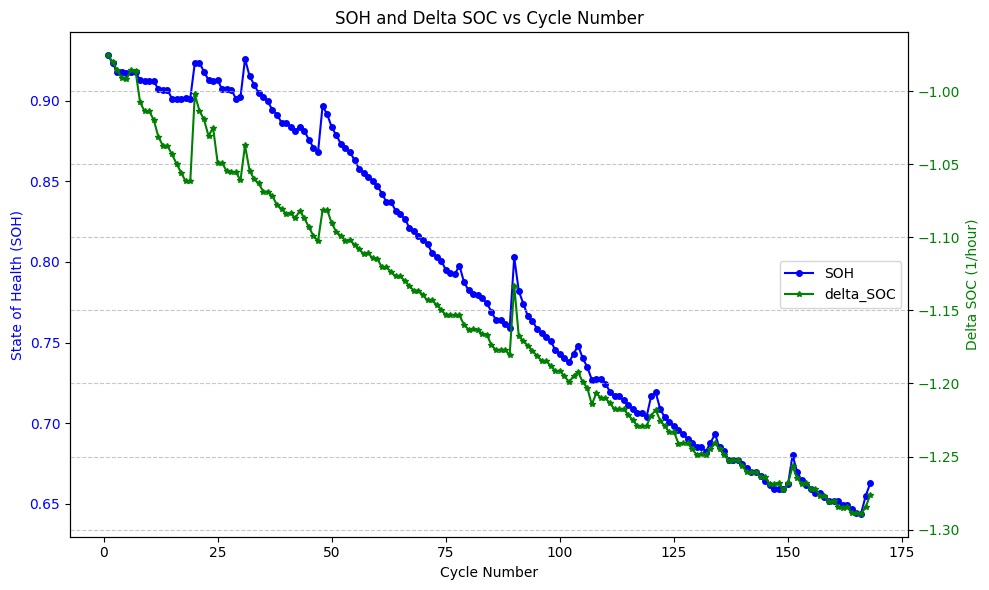

In [362]:
# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot SOH on first y-axis
ax1.plot(features["cycle"], features["SOH"], marker="o", color="blue", label="SOH", markersize=4)
ax1.set_ylabel("State of Health (SOH)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Plot delta_SOC on second y-axis
ax2.plot(features["cycle"], features["delta_SOC"], marker="*", color="green", label="delta_SOC", markersize=4)
ax2.set_ylabel("Delta SOC (1/hour)", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Set common x-axis label and title
plt.title("SOH and Delta SOC vs Cycle Number")
ax1.set_xlabel("Cycle Number")

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [363]:
# voltage and current fluctuations
features["voltage_mean"] = cycle_groups["voltage_measured"].mean().values
# features["voltage_std"] = cycle_groups["voltage_measured"].std()
features["voltage_min"] = cycle_groups["voltage_measured"].min().values
features["voltage_max"] = cycle_groups["voltage_measured"].max().values

features["current_mean"] = cycle_groups["current_measured"].mean().values
# features["current_std"] = cycle_groups["current_measured"].std()
features["current_min"] = cycle_groups["current_measured"].min().values
features["current_max"] = cycle_groups["current_measured"].max().values

In [364]:
#  Temperature fluctuations
features["temp_mean"] = cycle_groups["temperature_measured"].mean().values
# features["temp_std"] = cycle_groups["temperature_measured"].std()
features["temp_min"] = cycle_groups["temperature_measured"].min().values
features["temp_max"] = cycle_groups["temperature_measured"].max().values

In [365]:
features.iloc[0:5,:8]  # verify eol cycle

,cycle,capacity,SOH,delta_SOC,discharge_time,voltage_mean,voltage_min,voltage_max
0,1,1.856487,0.928244,-0.975548,3690.234,3.530458,2.73651,4.191492
1,2,1.846327,0.923164,-0.980300,3672.344,3.538082,2.73651,4.189773
2,3,1.835349,0.917675,-0.985858,3651.641,3.544171,2.73651,4.188187
3,4,1.835263,0.917631,-0.991309,3631.563,3.544406,2.73651,4.188461
4,5,1.834646,0.917323,-0.991962,3629.172,3.543318,2.73651,4.188299


### Computation of internal resistance feature

In [366]:
internal_resistances = []

for cycle, group in df_5_clean.groupby("cycle"):
    # Linear fit: V = E - I*r
    I = group["current_measured"].values
    V = group["voltage_measured"].values
    # Fit line: V = a + b*I => b = -r
    coeffs = np.polyfit(I, V, 1)
    r = -coeffs[0]  # negative slope
    internal_resistances.append({"cycle": cycle, "internal_resistance": r})

# Convert to DataFrame if needed
r_df = pd.DataFrame(internal_resistances)

features["internal_resistance"] = r_df["internal_resistance"].values
# Display the first few rows of cycle and internal_resistance columns
features[["cycle", "internal_resistance"]].head()

,cycle,internal_resistance
0,1,0.123718
1,2,0.121948
2,3,0.111277
3,4,0.116835
4,5,0.122119


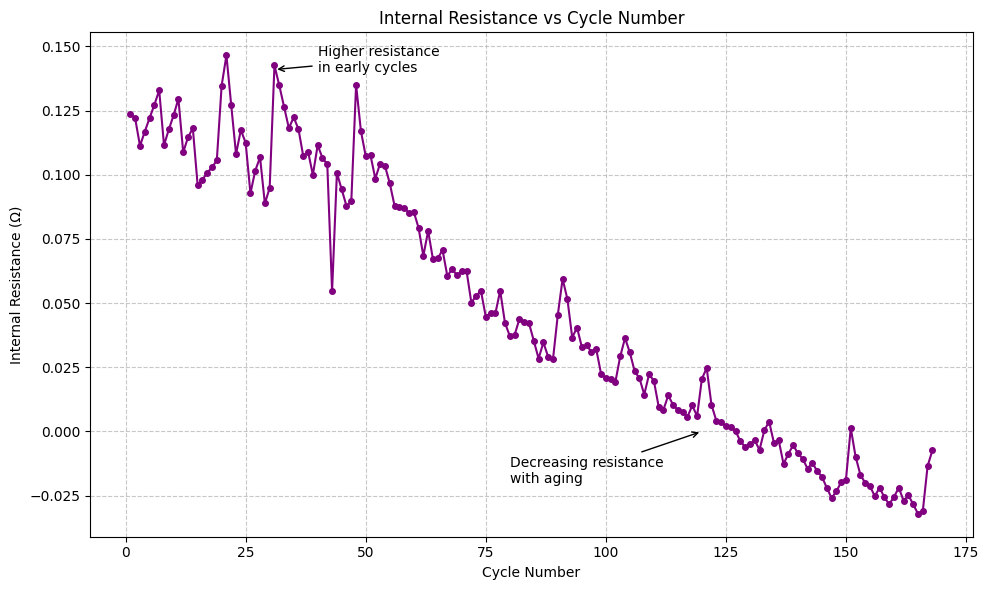

In [367]:
plt.figure(figsize=(10, 6))
plt.plot(
    features["cycle"],
    features["internal_resistance"],
    marker="o",
    linestyle="-",
    markersize=4,
    color="purple",
)
plt.title("Internal Resistance vs Cycle Number")
plt.xlabel("Cycle Number")
plt.ylabel("Internal Resistance (Ω)")
plt.grid(True, linestyle="--", alpha=0.7)

# Add annotations to highlight trend
plt.annotate(
    "Higher resistance\nin early cycles",
    xy=(31, 0.141),
    xytext=(40, 0.14),
    arrowprops=dict(arrowstyle="->"),
)

plt.annotate(
    "Decreasing resistance\nwith aging",
    xy=(120, 0),
    xytext=(80, -0.02),
    arrowprops=dict(arrowstyle="->"),
)

plt.tight_layout()
plt.show()

### Remaining useful life (RUL) is the amount of time/cycles a battery is likely to operate before it requires repair or replacement. 

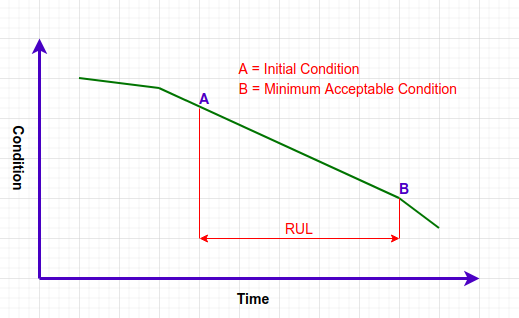

In [368]:
print(eol_cycle)

125


In [369]:
features["RUL"] = eol_cycle - features["cycle"]
features.tail(10)

,cycle,capacity,SOH,delta_SOC,discharge_time,...,temp_mean,temp_min,temp_max,internal_resistance,RUL
158,159,1.303033,0.651516,-1.280832,2810.672,...,33.174058,23.681326,40.817921,-0.028356,-34
159,160,1.303357,0.651679,-1.280462,2811.485,...,33.253985,23.748579,40.946994,-0.025535,-35
160,161,1.303410,0.651705,-1.284603,2802.422,...,33.319809,23.789079,41.074938,-0.021900,-36
161,162,1.297887,0.648944,-1.284969,2801.625,...,33.337658,23.827460,41.024764,-0.027007,-37
162,163,1.298074,0.649037,-1.284782,2802.031,...,33.290767,23.738230,41.062142,-0.024865,-38
163,164,1.293464,0.646732,-1.288757,2793.390,...,33.275688,23.736113,40.983663,-0.028381,-39
164,165,1.288003,0.644002,-1.288757,2793.390,...,33.320678,23.800266,40.982342,-0.032093,-40
165,166,1.287453,0.643726,-1.289174,2792.485,...,33.373150,23.849122,41.063751,-0.031010,-41
166,167,1.309015,0.654508,-1.284789,2802.016,...,33.713519,24.921957,41.047030,-0.013468,-42
167,168,1.325079,0.662540,-1.276419,2820.390,...,33.865318,25.093297,41.051008,-0.007398,-43


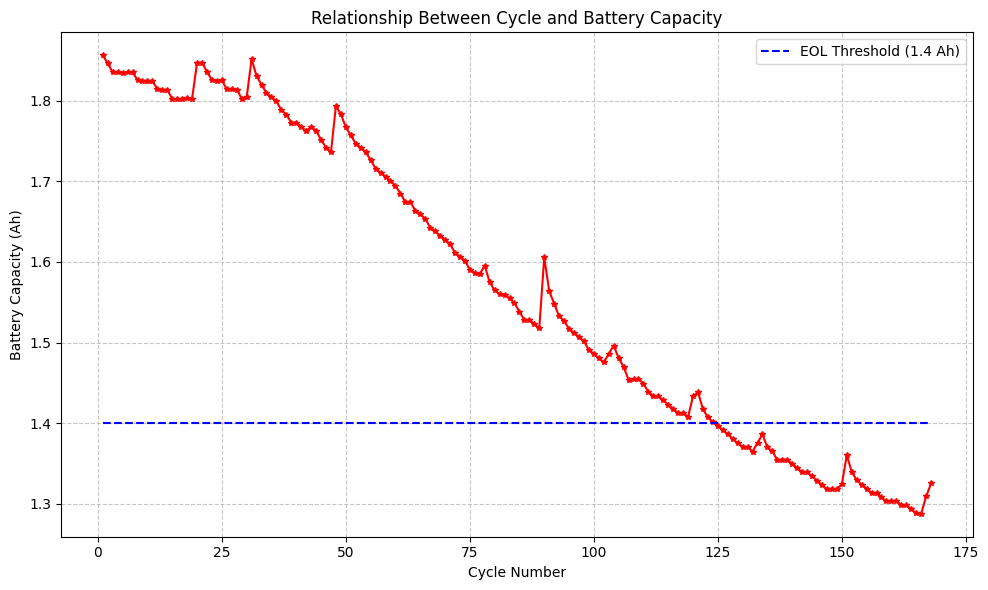

In [370]:
# Plot the relationship between cycle and battery capacity.
plt.figure(figsize=(10, 6))
plt.plot(features["cycle"], features["capacity"], marker="*", color="r", markersize=4)
# Draw threshold line for EOL
eol_threshold = np.full_like(features["cycle"], eol_capacity, dtype=float)
plt.plot(features["cycle"], eol_threshold, "--", color="blue", label="EOL Threshold (1.4 Ah)")
plt.title("Relationship Between Cycle and Battery Capacity")
plt.xlabel("Cycle Number")
plt.ylabel("Battery Capacity (Ah)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

plt.legend()

plt.show()

In [371]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cycle                168 non-null    int64  
 1   capacity             168 non-null    float64
 2   SOH                  168 non-null    float64
 3   delta_SOC            168 non-null    float64
 4   discharge_time       168 non-null    float64
 5   voltage_mean         168 non-null    float64
 6   voltage_min          168 non-null    float64
 7   voltage_max          168 non-null    float64
 8   current_mean         168 non-null    float64
 9   current_min          168 non-null    float64
 10  current_max          168 non-null    float64
 11  temp_mean            168 non-null    float64
 12  temp_min             168 non-null    float64
 13  temp_max             168 non-null    float64
 14  internal_resistance  168 non-null    float64
 15  RUL                  168 non-null    int

# Input Feature Selection

### Determin feature importance using correletaion

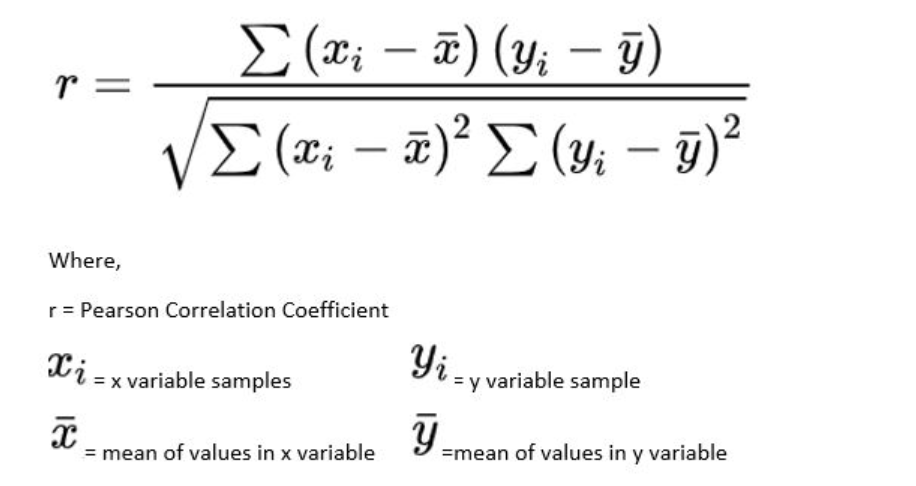

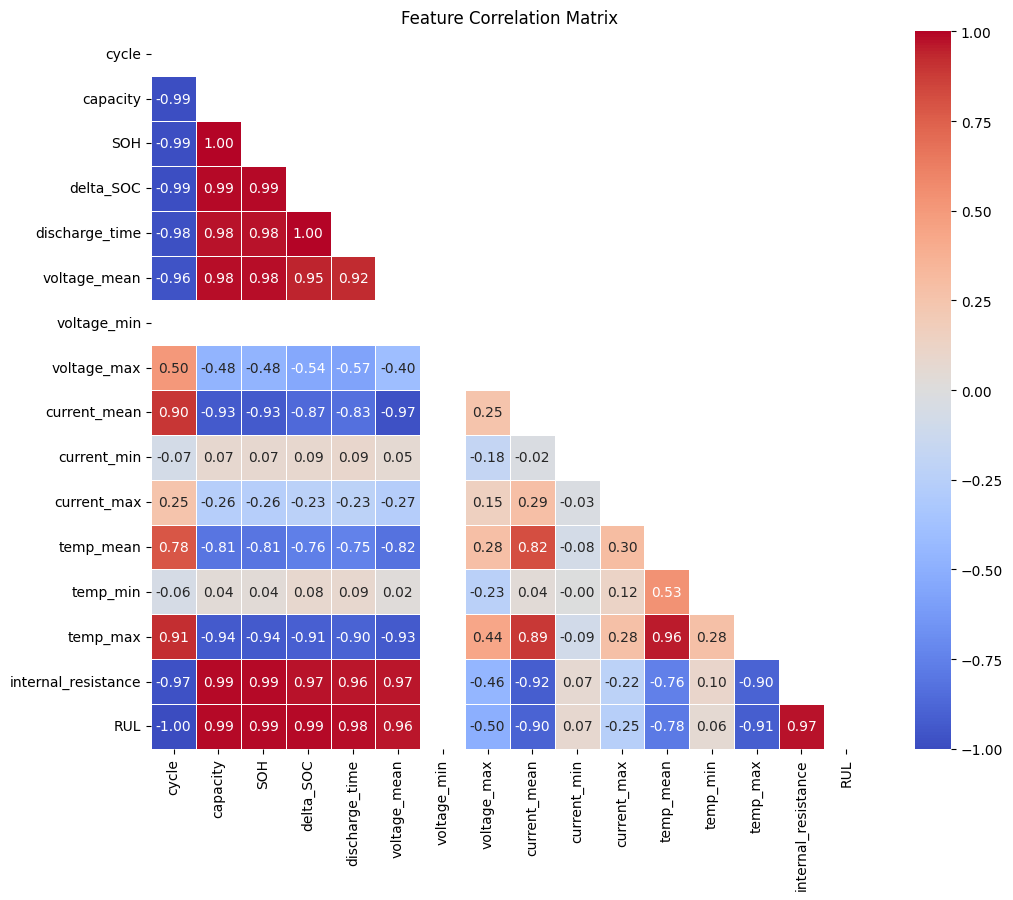

In [372]:
# Compute correlation matrix
correlation_matrix = features.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(11, 9))

# Create heatmap using seaborn
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make cells square
            linewidths=0.5)  # Add lines between cells

plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# # Find highly correlated features (correlation > 0.8)
# threshold = 0.8
# high_corr = np.where(np.abs(correlation_matrix) > threshold)
# high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
#              for x, y in zip(*high_corr) if x != y]

# print("\nHighly correlated features (|correlation| > 0.8):")
# for feat1, feat2, corr in high_corr:
#     print(f"{feat1} - {feat2}: {corr:.3f}")

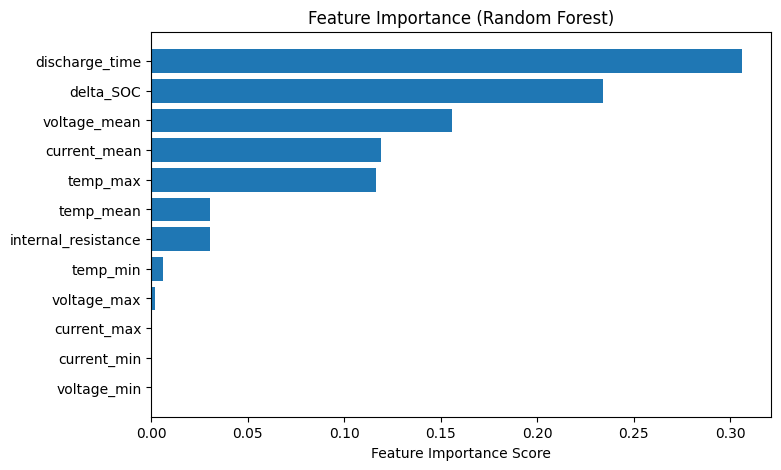

In [373]:
from sklearn.ensemble import RandomForestRegressor


X = features.drop(columns=["RUL", "cycle", "capacity", "SOH"])  # Drop the target variable and non-feature columns
y = features["RUL"]

model = RandomForestRegressor()
model.fit(X, y)

# Plot feature importance
importances = model.feature_importances_
all_features = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(importances)), importances[sorted_idx], align="center")
plt.yticks(range(len(importances)), [all_features[i] for i in sorted_idx])
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.show()

## Normalize the features

In [374]:
features.head()

,cycle,capacity,SOH,delta_SOC,discharge_time,...,temp_mean,temp_min,temp_max,internal_resistance,RUL
0,1,1.856487,0.928244,-0.975548,3690.234,...,32.572328,24.325993,38.982181,0.123718,124
1,2,1.846327,0.923164,-0.980300,3672.344,...,32.725235,24.685948,39.033398,0.121948,123
2,3,1.835349,0.917675,-0.985858,3651.641,...,32.642862,24.734266,38.818797,0.111277,122
3,4,1.835263,0.917631,-0.991309,3631.563,...,32.514876,24.652244,38.762305,0.116835,121
4,5,1.834646,0.917323,-0.991962,3629.172,...,32.382349,24.518700,38.665393,0.122119,120


In [375]:
# Select features for training
selected_features = ["delta_SOC", "discharge_time", "voltage_mean", "current_mean", "temp_max", "internal_resistance"]
inputs = features[selected_features]
target = features["RUL"]  

### Split into train and test sets

Mean Absolute Error (MAE): 2.57 cycles
Mean Squared Error (MSE): 12.53
Root Mean Squared Error (RMSE): 3.54 cycles
R² Score: 0.9953


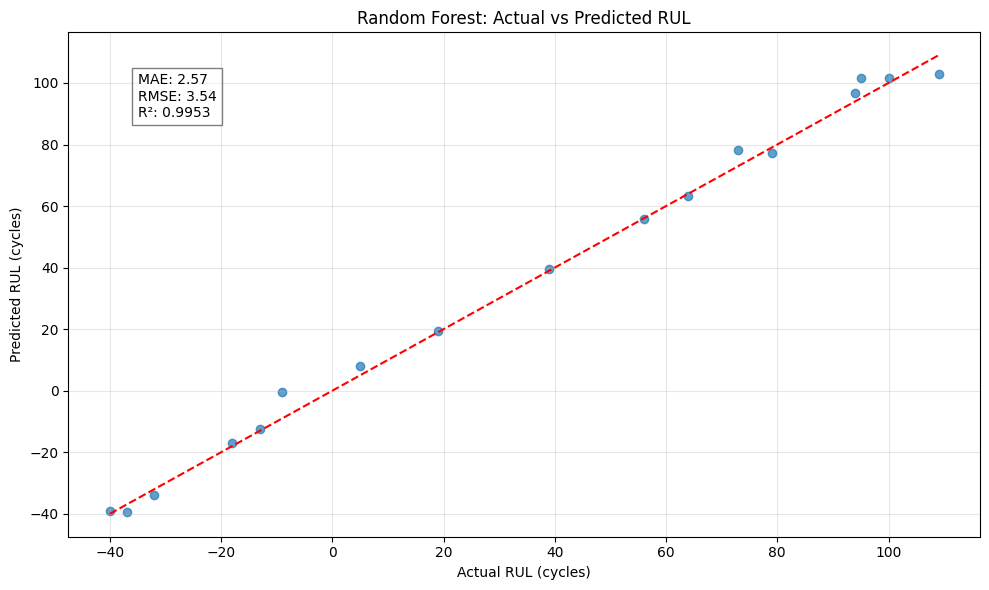

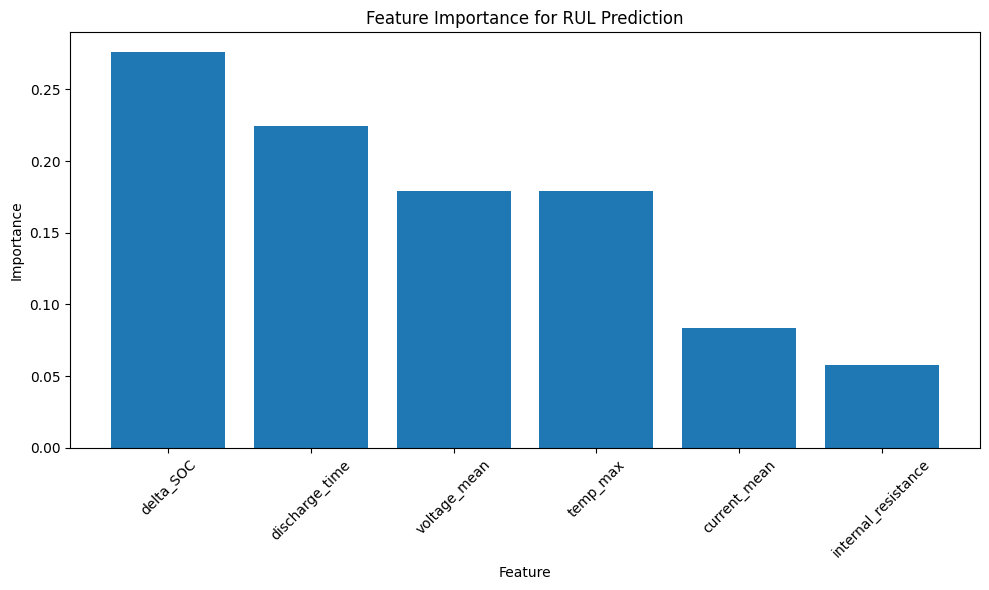

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.1, random_state=42)

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} cycles")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} cycles")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title('Random Forest: Actual vs Predicted RUL')
plt.grid(True, alpha=0.3)

# Add text with metrics
plt.text(y_test.min() + 5, y_test.max() - 20, 
         f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}", 
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [377]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [378]:
# Save the model
import joblib

joblib.dump(rf_model, "battery_rul_model.pkl")

['battery_rul_model.pkl']

In [381]:
print(X_train)

     delta_SOC  discharge_time  voltage_mean  current_mean   temp_max  \
109  -1.210090        2974.985      3.496251     -1.758822  41.196960   
75   -1.153061        3122.125      3.521509     -1.831596  39.637081   
108  -1.209963        2975.297      3.496467     -1.765572  41.060262   
19   -1.002301        3591.734      3.552581     -1.855371  38.447499   
16   -1.055878        3409.484      3.561231     -1.902762  38.319269   
..         ...             ...           ...           ...        ...   
71   -1.143186        3149.094      3.528783     -1.844882  39.535351   
106  -1.214383        2964.468      3.496892     -1.770370  40.690125   
14   -1.043388        3450.297      3.562973     -1.881777  38.213586   
92   -1.174168        3066.000      3.515235     -1.803361  40.278048   
102  -1.195219        3012.000      3.498642     -1.780968  40.584997   

     internal_resistance  
109             0.019747  
75              0.046127  
108             0.022214  
19             

Mean Absolute Error (MAE): 1.12 cycles
Mean Squared Error (MSE): 2.91
Root Mean Squared Error (RMSE): 1.71 cycles
R² Score: 0.9987


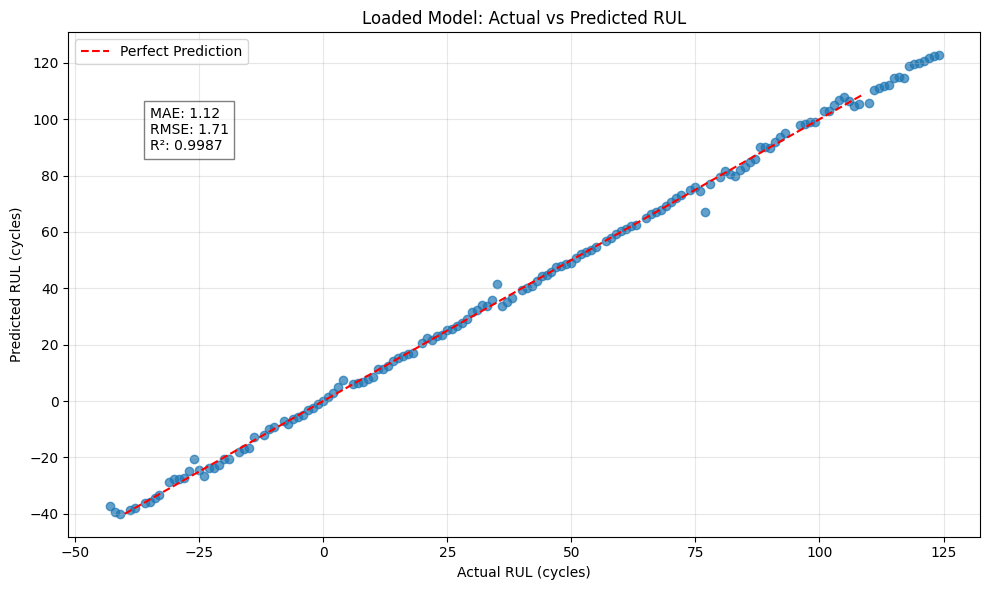

In [380]:
# Load the model
loaded_model = joblib.load("battery_rul_model.pkl")

# Make predictions with the loaded model
y_pred_loaded = loaded_model.predict(X_train)

# Calculate metrics
mae_loaded = mean_absolute_error(y_train, y_pred_loaded)
mse_loaded = mean_squared_error(y_train, y_pred_loaded)
rmse_loaded = np.sqrt(mse_loaded)
r2_loaded = r2_score(y_train, y_pred_loaded)

print(f"Mean Absolute Error (MAE): {mae_loaded:.2f} cycles")
print(f"Mean Squared Error (MSE): {mse_loaded:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_loaded:.2f} cycles")
print(f"R² Score: {r2_loaded:.4f}")

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_loaded, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title('Loaded Model: Actual vs Predicted RUL')
plt.grid(True, alpha=0.3)

# Add text with metrics
plt.text(y_test.min() + 5, y_test.max() - 20, 
         f"MAE: {mae_loaded:.2f}\nRMSE: {rmse_loaded:.2f}\nR²: {r2_loaded:.4f}", 
         bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.tight_layout()
plt.show()

In [331]:
# # Compute average discharge current per cycle
# discharge_data = df_clean[df_clean["current_measured"] < 0.01]
# avg_current_per_cycle = discharge_data.groupby("cycle")["current_measured"].mean().abs()

# # Merge average current with discharge time
# est_capacity = cycle_time_df.copy()
# est_capacity["Avg Current (A)"] = est_capacity["Cycle"].map(avg_current_per_cycle)

# # Estimate capacity from fundamental relation: Capacity (Ah) = (Time (s) × Current (A)) / 3600
# est_capacity["Estimated Capacity (Ah)"] = (
#     est_capacity["Discharge Time (s)"] * est_capacity["Avg Current (A)"] / 3600
# )

# print("Formula: Battery Capacity (Ah) = (Discharge Time (s) × Avg Current (A)) / 3600")
# est_capacity.head()